# Local coordinate aperture photometry for input to AAVSO DSLR data worksheet
### Uses Python 3, astropy, matplotlib, PythonPhot

## Definitions

### Imports

In [1]:
import os
from random import random
from collections import OrderedDict

import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.visualization import astropy_mpl_style

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
# TODO: why importing as tuple?
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
plt.style.use(astropy_mpl_style)
%matplotlib inline

from PythonPhot import aper

### Functions

#### Photometry of a list of FITS files, creating a table of times and instrumental magnitudes

In [2]:
def multi_file_photometry(fits_root, fits_files, data_index, coords, dataframe, 
                          aperture_radius, inner_sky_radius, outer_sky_radius, 
                          gain=1, zeropoint=0, suffix='.fit'):
    
    for fits_file in fits_files:
        fits_file_path = os.path.join(fits_root, fits_file)
        hdus = fits.open(fits_file_path)
            
        instr_mags = []
        for x, y in coords:
            time, mag = aperture_photometry(hdus[data_index], x, y, 
                                            aperture_radius, inner_sky_radius, outer_sky_radius,
                                            gain=gain, zeropoint=zeropoint)
            instr_mags.append(mag)
        
        dataframe[fits_file[0:fits_file.rindex(suffix)]] = [time] + instr_mags  

#### Single image+coordinate photometry, returning a time and instrumental magnitude
#### Invoked by multi_file_photometry()

In [3]:
def aperture_photometry(hdu, x, y, 
                        aperture_radius, inner_sky_radius, outer_sky_radius, 
                        gain=1, zeropoint=0):

    image_data = hdu.data
    time = hdu.header[time_name]
        
    mag, magerr, flux, fluxerr, sky, skyerr, badflag, outstr = \
                aper.aper(image_data, x, y, phpadu=gain, 
                          apr=aperture_radius, zeropoint=zeropoint,
                          skyrad=[inner_sky_radius, outer_sky_radius], 
                          exact=True)

    return time, mag[0]

#### Display an image with target and reference stars annotated, to sanity check local coordinates

In [2]:
def show_image(image_data, coord_map, aperture_size, annotate=True, vmin=10, vmax=200, figx=20, figy=10):
    fig = plt.figure(figsize=(figx, figy))
    plt.imshow(image_data, cmap='gray', vmin=vmin, vmax=vmax)
    plt.gca().invert_yaxis()
    plt.colorbar()

    if annotate:
        for designation in coord_map:
            xy = coord_map[designation]
            annotate_image(fig.axes[0], designation, xy, aperture_size)
    
    plt.show()

#### Annotate plot axis with coordinate positions and designations
#### Invoked by show_image()

In [5]:
def annotate_image(axis, designation, xy, aperture_size):
    axis.plot(xy[0], xy[1], 'o', markersize=aperture_size, 
              markeredgecolor='r', markerfacecolor='none', 
              markeredgewidth=2)
    
    offsetbox = TextArea(designation, minimumdescent=False)

    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(-20, 40+random()*10-10),
                        xycoords='data',
                        boxcoords="offset points",
                        arrowprops=dict(arrowstyle="->"))
    
    axis.add_artist(ab)        

## Inputs
### Change these to suit your environment

#### File settings

In [6]:
# Instrumental magnitude output file path
instr_mag_file_root = "/Users/david/_photometry_working"
instr_mag_csv_file = "instr_mags.csv"

# FITS file directory
fits_root = "/Users/david/_photometry_working"

# B, G, and R FITS file prefixes to identify files,
# e.g. stk-median-g matches stk-median-g1.fit, stk-median-g2.fit, ... 
fits_prefixes = ["stk-median-b", "stk-median-g", "stk-median-r"]

# FITS file data HDU index
data_index = 0

# Time column name
time_name = "JD"

#### Map of object designations to local coordinates

In [7]:
# TODO: this ordering only holds because I'm using Py 3.6!! Change to position_map[...] = ()

# Ordered dictionary of object names/IDs to local coordinates
position_map = OrderedDict({
 # ** Your name-coordinate mappings go here **
"eta Car":(2188.101,1350.250),
"45 000-BBR-533":(2911.183,1727.747), # (furthest east) (CHK)
"46 000-BBR-603":(2088.885,1067.720), # (furthest west) 
"46 000-BBS-066":(1082.639,1707.460), # (furthest east)
"47 000-BBR-573":(2501.905,1350.379), # (furthest east)
"51 000-BBR-998":(992.812,1149.498),  # (furthest east)
"52 000-BBR-795":(2321.108,2213.099), # (furthest east)
"55 000-BBR-563":(2629.498,1445.678)
 # ** END **
})

#### Aperture radii and gain

In [8]:
# Aperture radii
measurement_aperture = 12
inner_sky_annulus = 15
outer_sky_annulus = 20

# ph/ADU
# Note: PythonPhot's aperture photometry function takes a phadu parameter.
# Assumption: this is photons/ADU or e-/ADU, i.e. gain.
gain=1.67

## Outputs

### Find B, G, R files in the FITS file directory

In [9]:
files = os.listdir(fits_root)

fits_files = []
for fits_prefix in fits_prefixes:
    fits_files += sorted([file for file in files if fits_prefix in file])

### Aperture location sanity check by visual inspection
#### Arbitrarily choose the first G FITS file

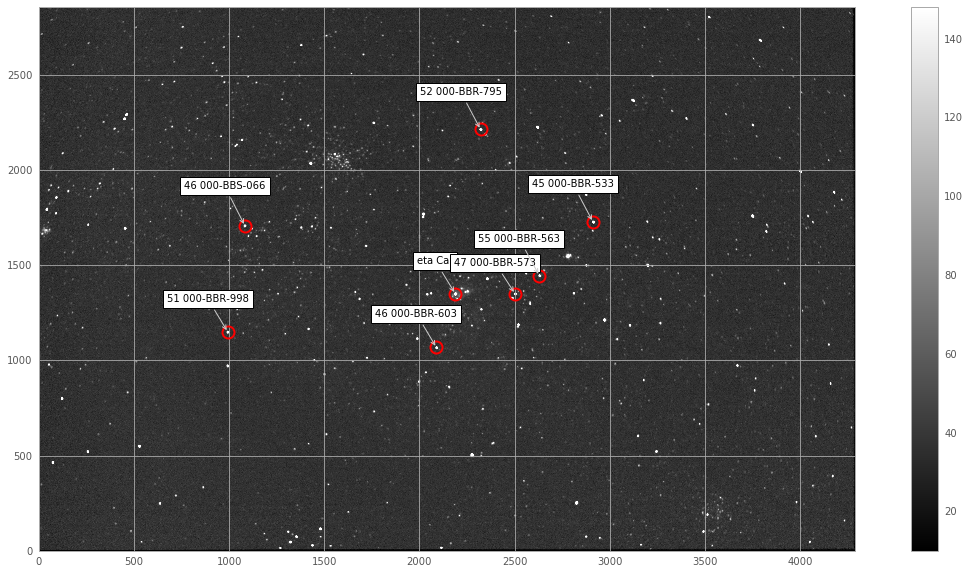

In [10]:
fits_file = fits_files[0]

hdus = fits.open(os.path.join(fits_root, fits_file))
image_data = hdus[data_index].data

median = np.median(image_data)
show_image(image_data, position_map, measurement_aperture, annotate=True, vmin=10, vmax=median*4)

### Aperture photometry

In [11]:
# Create empty table with time and object headers
pd.options.display.float_format = '{:,.6f}'.format
instr_mag_df = pd.DataFrame()
names = [name for name in position_map]
instr_mag_df['name'] = [time_name] + names
instr_mag_df.set_index('name', inplace=True)

In [12]:
# Carry out photometry on B, G, R FITS files, yielding instrumental magnitudes
positions = position_map.values()

multi_file_photometry(fits_root, fits_files, data_index, positions, instr_mag_df, 
                      measurement_aperture, inner_sky_annulus, outer_sky_annulus, gain=gain)

In [13]:
# Save photometry table as CSV
instr_mag_csv_path = os.path.join(instr_mag_file_root, instr_mag_csv_file)
instr_mag_df.T.to_csv(instr_mag_csv_path)

# Display photometry table
instr_mag_df.T

name,JD,eta Car,45 000-BBR-533,46 000-BBR-603,46 000-BBS-066,47 000-BBR-573,51 000-BBR-998,52 000-BBR-795,55 000-BBR-563
stk-median-b1,"2,458,212.078817",-12.653203,-11.889155,-11.693347,-12.360838,-11.705838,-11.991409,-11.975165,-11.547687
stk-median-b2,"2,458,212.079288",-12.676716,-11.888247,-11.710847,-12.352918,-11.725009,-11.993802,-11.971802,-11.566899
stk-median-b3,"2,458,212.079760",-12.657703,-11.887115,-11.675094,-12.362197,-11.704079,-12.006511,-11.960851,-11.523285
stk-median-b4,"2,458,212.080229",-12.646539,-11.874352,-11.660195,-12.347838,-11.694267,-11.966581,-11.952618,-11.541032
stk-median-b5,"2,458,212.080700",-12.679523,-11.880402,-11.660169,-12.361731,-11.717250,-11.980377,-11.973680,-11.553478
stk-median-g1,"2,458,212.078817",-13.038560,-12.749665,-12.606107,-12.711877,-12.526270,-12.178089,-12.133388,-11.890305
stk-median-g2,"2,458,212.079288",-13.057241,-12.761668,-12.619061,-12.718656,-12.540526,-12.201056,-12.142204,-11.912867
stk-median-g3,"2,458,212.079760",-13.046109,-12.759615,-12.601629,-12.724608,-12.526093,-12.195183,-12.121514,-11.890221
stk-median-g4,"2,458,212.080229",-13.035322,-12.750870,-12.574980,-12.698287,-12.515768,-12.166241,-12.112183,-11.890527
stk-median-g5,"2,458,212.080700",-13.054921,-12.749772,-12.588711,-12.716304,-12.533579,-12.179150,-12.131609,-11.886901


In [96]:
# TODO: to do this properly, create separate IM DFs above and summarise each here
# The multiple DFs above can be merged for display and written as a single file for
# input into next stage of analysis (spreadsheet)

# cols = [col for col in instr_mag_df.columns]# if col.startswith(fits_prefixes[0])]    
# mean_df = pd.DataFrame(columns=cols)
# stdev_df = pd.DataFrame(columns=cols)

# for fits_prefix in fits_prefixes:
#     row_names = instr_mag_df.T.columns
#     row = [fits_prefix]
#     for row_index, row_name in enumerate(row_names):
#         row.append(instr_mag_df[cols].loc[row_name])
#     #mean_df.loc[row_index] = [row_name, np.mean(row)]
#     #stdev_df.loc[row_index] = [row_name, np.mean(row)]

# mean_df
# stdev_df

,stk-median-b1,stk-median-b2,stk-median-b3,stk-median-b4,stk-median-b5,stk-median-g1,stk-median-g2,stk-median-g3,stk-median-g4,stk-median-g5,stk-median-r1,stk-median-r2,stk-median-r3,stk-median-r4,stk-median-r5


## Links
* http://docs.astropy.org/en/stable/io/fits
* http://docs.astropy.org/en/stable/generated/examples/io/plot_fits-image.html
* http://www.astropy.org/astropy-tutorials/FITS-images.html
* https://github.com/djones1040/PythonPhot
* https://gist.github.com/dokeeffe/416e214f134d39db696c7fdac261964b